<a href="https://colab.research.google.com/github/chadeswetha/-Plant-Leaf-Disease-Detection-and-Classification-using-Advanced-LBP-and-Grad-CAM/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !ls /content/drive/MyDrive/dataset

F-plant.zip


Imports

In [ ]:
import numpy as np
import pickle
import os
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential  # Use tensorflow.keras for compatibility
#from keras.layers.normalization import BatchNormalization # Remove this line - BatchNormalization is deprecated in newer Keras
from tensorflow.keras.layers import BatchNormalization # Import BatchNormalization from tensorflow.keras.layers
from tensorflow.keras.layers import Conv2D  # Use tensorflow.keras for compatibility
from tensorflow.keras.layers import MaxPooling2D  # Use tensorflow.keras for compatibility
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense  # Use tensorflow.keras for compatibility
from tensorflow.keras import backend as K  # Use tensorflow.keras for compatibility
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras for compatibility
from tensorflow.keras.optimizers import Adam  # Use tensorflow.keras for compatibility
from tensorflow.keras.preprocessing import image  # Use tensorflow.keras for compatibility
from tensorflow.keras.preprocessing.image import img_to_array  # Use tensorflow.keras for compatibility
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# example of loading an image with the Keras API
from keras.preprocessing.image import load_img

In [ ]:
  import zipfile

  # Specify the path to the zip file
  zip_file_path = '/content/archive (4).zip'

  # Specify the directory to extract to
  extract_to_dir = '/content/Plant'  # You can change this if needed

  # Extract the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to_dir)

  print(f"PlantVillage.zip extracted to {extract_to_dir}")

  # Update directory_root to point to the extracted folder
  directory_root = extract_to_dir

PlantVillage.zip extracted to /content/Plant


In [ ]:
import os

image_folder_path = '/content/Plant/PlantVillage'  # Replace with your actual path

try:
    image_files = os.listdir(image_folder_path)
    print("Files in the image folder:")
    for filename in image_files:
        print(filename)
except FileNotFoundError:
    print(f"Error: The folder '{image_folder_path}' was not found. Please double-check the path.")
except Exception as e:
    print(f"An error occurred: {e}")



Files in the image folder:
Tomato_Early_blight
Tomato__Target_Spot
Tomato_Leaf_Mold
Pepper__bell___Bacterial_spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Late_blight
Potato___healthy
Tomato_Septoria_leaf_spot
Tomato__Tomato_mosaic_virus
Tomato_Spider_mites_Two_spotted_spider_mite
Pepper__bell___healthy
Tomato_Bacterial_spot
Potato___Late_blight
Potato___Early_blight
Tomato_healthy


In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/Plant'
width=256
height=256
depth=3

In [ ]:
# Define the dataset directory path
folder_path =image_folder_path

# Get the list of class names (subdirectories in the folder)
classes = os.listdir(folder_path)

# Count the number of classes
num_classes = len(classes)

# Print the number of classes and their names
print("Number of classes:", num_classes)
print(classes)

Number of classes: 15
['Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Potato___healthy', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Potato___Late_blight', 'Potato___Early_blight', 'Tomato_healthy']


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
import cv2
import numpy as np
from skimage import feature
#from google.colab.patches import cv2_imshow

# Completed Local Binary Pattern (CLBP) with enhancement

def completed_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, 8, 1, method="uniform")
    clbp_s = (lbp >= 0).astype(int)
    clbp_m = (gray >= np.mean(gray)).astype(int)
    clbp_c = np.mean(gray)
    return clbp_s, clbp_m, clbp_c

def enhance_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray)

    # Apply Sobel edge detection to highlight textures
    sobelx = cv2.Sobel(enhanced_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(enhanced_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    sobel_combined = cv2.convertScaleAbs(sobel_combined)

    # Apply normalization for better visualization
    normalized_image = cv2.normalize(sobel_combined, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    return enhanced_gray, sobel_combined, normalized_image

def show_clbp(image, clbp_s, clbp_m):
    clbp_s_display = (clbp_s * 255).astype(np.uint8)
    clbp_m_display = (clbp_m * 255).astype(np.uint8)
    enhanced_gray, sobel_combined, normalized_image = enhance_image(image)

    # Add padding for better separation
    padding = 20
    empty_space = np.ones((image.shape[0], padding, 3), dtype=np.uint8) * 255

    # Combine results for visualization
    combined_image = np.hstack((
        image, empty_space,
        cv2.cvtColor(clbp_s_display, cv2.COLOR_GRAY2BGR), empty_space,
        #cv2.cvtColor(clbp_m_display, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(sobel_combined, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
    ))
    cv2_imshow(combined_image)

In [ ]:
# Apply CLBP and prepare image for model
def convert_image_to_array_with_clbp(image_path):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (256, 256))  # resize image

        clbp_s, _, _ = completed_lbp(image)

        # Normalize and convert 1-channel to 3-channel
        clbp_s = clbp_s.astype("float32")
        clbp_s = cv2.resize(clbp_s, (256, 256))
        clbp_s_3ch = np.stack((clbp_s,) * 3, axis=-1)

        return clbp_s_3ch
    except Exception as e:
        print(f"Error processing image: {image_path} -> {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array_with_clbp(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
print(image_size)

2951


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
labels=label_binarizer.classes_
print(labels)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 693ms/step - accuracy: 0.2237 - loss: 0.7550 - val_accuracy: 0.0694 - val_loss: 0.8725
Epoch 2/25
 1/73 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.4375 - loss: 0.2631

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4375 - loss: 0.2631 - val_accuracy: 0.0694 - val_loss: 0.9166
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.4444 - loss: 0.2149 - val_accuracy: 0.1354 - val_loss: 0.8643
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 0.1340 - val_accuracy: 0.1624 - val_loss: 0.6014
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 477ms/step - accuracy: 0.5441 - loss: 0.1886 - val_accuracy: 0.1624 - val_loss: 1.3099
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4375 - loss: 0.2917 - val_accuracy: 0.1607 - val_loss: 1.2558
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - accuracy: 0.4968 - loss: 0.2168 - val_accuracy: 0.1997 - val_loss: 0.8929
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5312 - loss: 0.1980 - val_accuracy: 0.1895 - val_loss: 0.8582
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 479ms/step - accuracy: 0.6526 - loss: 0.1562 - val_accuracy: 0.1574 - val_loss

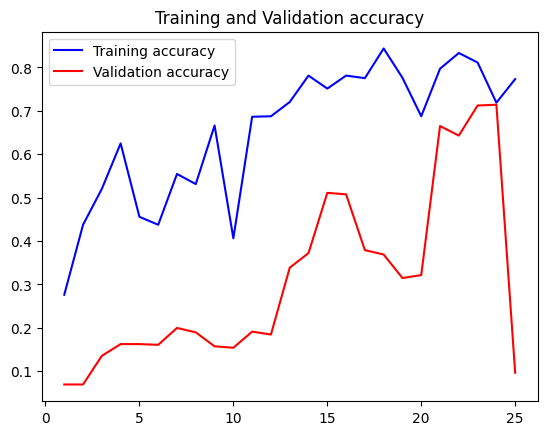

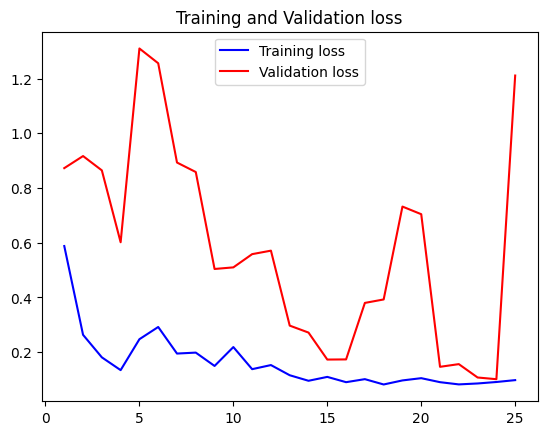

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*1000}")

[INFO] Calculating model accuracy
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0894 - loss: 1.2173
Test Accuracy: 96.4467003941536


In [ ]:
model.save('PlantVillage.h5')

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
import pickle

# 1. Load the label encoder from the pickle file
with open('/content/label_transform.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# 2. Display the classes (labels) learned by the label encoder
print("Classes (Labels) in the Label Encoder:")
print(label_encoder.classes_)


Classes (Labels) in the Label Encoder:
['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the trained model
model = load_model("/content/PlantVillage.h5")  # Ensure the correct model format

# Define image dimensions
img_width, img_height = 256, 256  # Adjust as per model requirements

# Load an image for prediction (update with actual image path)
image_dir = "/content/Plant/PlantVillage/Potato___Late_blight"  # Path to the directory containing images
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
img_path = os.path.join(image_dir, image_files[0]) # Path to a specific image file

img = image.load_img(img_path, target_size=(img_width, img_height))  # Resize image
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Predict class probabilities
class_probabilities = model.predict(img_array)

# Get the predicted class index
predicted_label = np.argmax(class_probabilities)

# Define class labels properly
class_labels = labels

# Get predicted label name
predicted_label_name = class_labels[predicted_label]

# Display prediction result
print("Predicted label:", predicted_label_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: Pepper__bell___healthy


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step


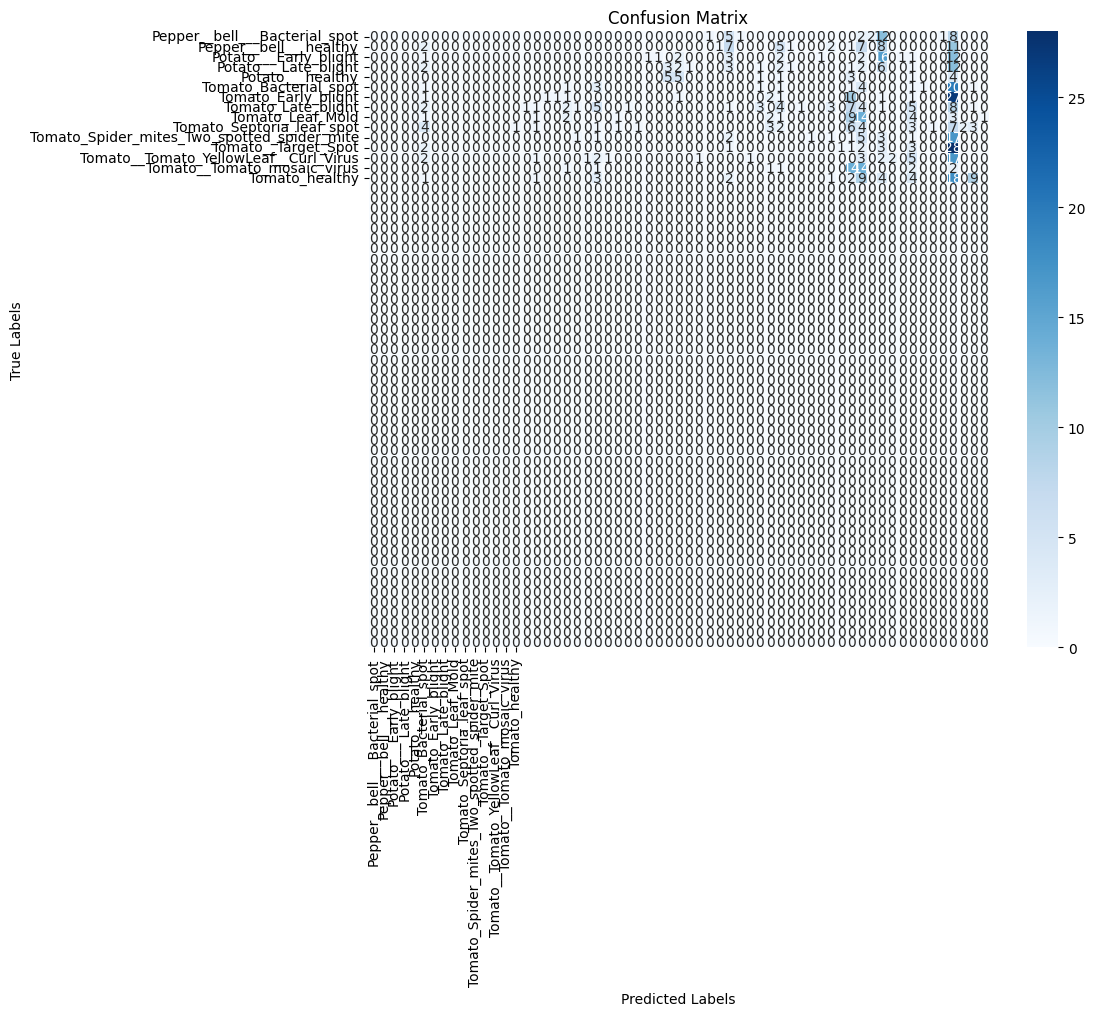

In [ ]:
# prompt: code for confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_test (true labels) and predictions from your model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


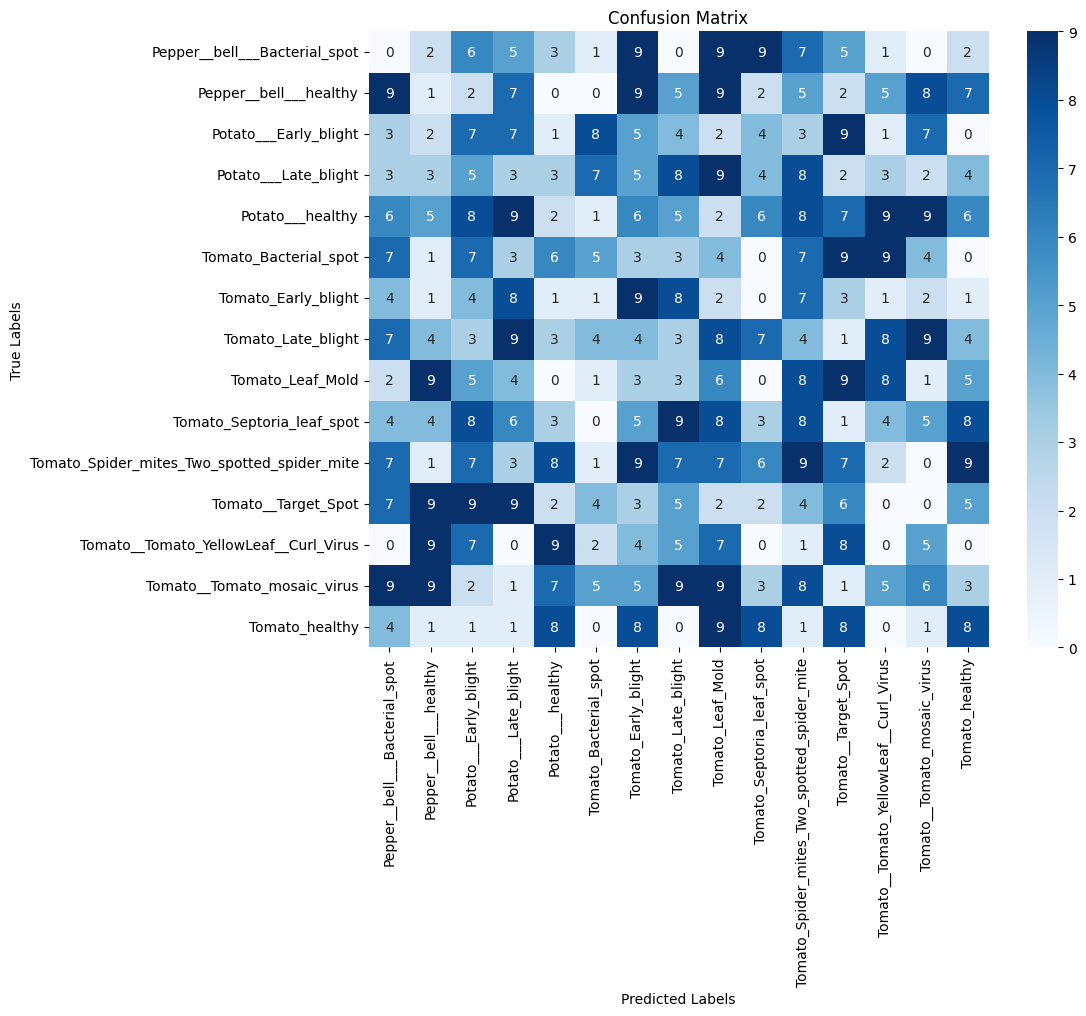

In [ ]:
# prompt: heatmap

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Generate a sample confusion matrix (replace with your actual data)
import numpy as np
conf_matrix = np.random.randint(0, 10, size=(len(labels),len(labels))) #replace this with your confusion matrix

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Grad-cam

In [ ]:
import os

# Set TensorFlow as the backend for Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras  # High-level API for deep learning

# Display utilities
from IPython.display import Image, display  # For displaying images in Jupyter Notebook
import matplotlib as mpl
import matplotlib.pyplot as plt  # For data visualization


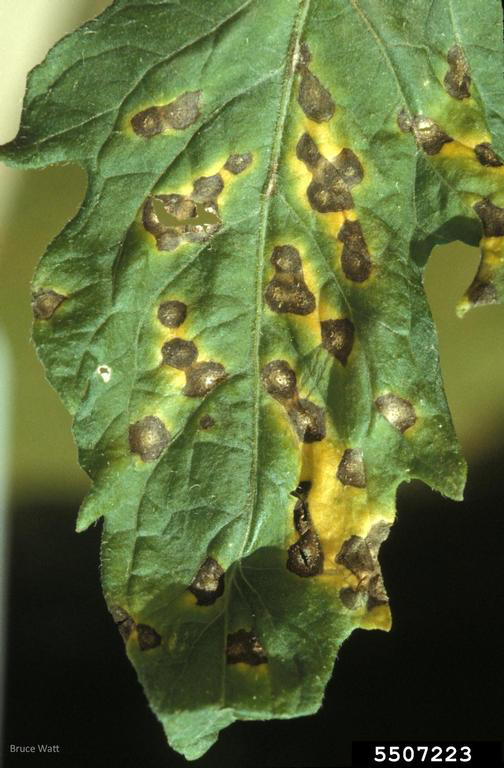

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = "/content/tomato-septoria-leaf-spot.png"

display(Image(img_path))

In [ ]:
#The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predicted: [('n12267677', 'acorn', np.float32(9.138944))]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


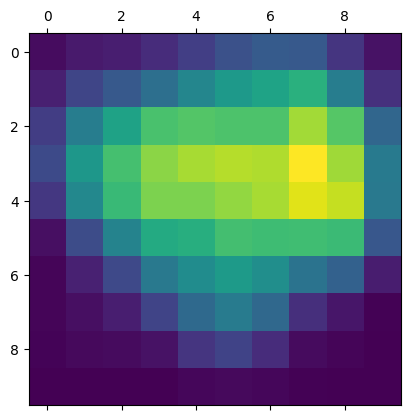

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

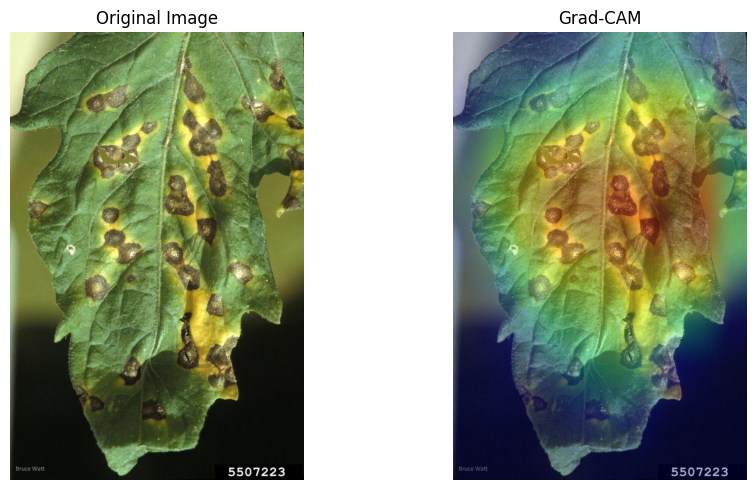

In [ ]:
# prompt: show original img aslo side by side

import matplotlib.pyplot as plt
from IPython.display import Image, display

# ... (your existing code) ...

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))




# Assuming img_path is defined as before
# Display original image and Grad-CAM side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figure size as needed

# Display original image
axes[0].imshow(plt.imread(img_path))
axes[0].set_title("Original Image")
axes[0].axis('off')  # Hide axes for better visualization

# Display Grad-CAM
save_and_display_gradcam(img_path, heatmap) #This will save the image and display
axes[1].imshow(plt.imread("cam.jpg"))
axes[1].set_title("Grad-CAM")
axes[1].axis('off')

plt.tight_layout() #Adjust spacing
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage import feature
from google.colab.patches import cv2_imshow

# Completed Local Binary Pattern (CLBP) with enhancement

def completed_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, 8, 1, method="uniform")
    clbp_s = (lbp >= 0).astype(int)
    clbp_m = (gray >= np.mean(gray)).astype(int)
    clbp_c = np.mean(gray)
    return clbp_s, clbp_m, clbp_c

def enhance_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray)

    # Apply Sobel edge detection to highlight textures
    sobelx = cv2.Sobel(enhanced_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(enhanced_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    sobel_combined = cv2.convertScaleAbs(sobel_combined)

    # Apply normalization for better visualization
    normalized_image = cv2.normalize(sobel_combined, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    return enhanced_gray, sobel_combined, normalized_image

def show_clbp(image, clbp_s, clbp_m):
    clbp_s_display = (clbp_s * 255).astype(np.uint8)
    clbp_m_display = (clbp_m * 255).astype(np.uint8)
    enhanced_gray, sobel_combined, normalized_image = enhance_image(image)

    # Add padding for better separation
    padding = 20
    empty_space = np.ones((image.shape[0], padding, 3), dtype=np.uint8) * 255

    # Combine results for visualization
    combined_image = np.hstack((
        image, empty_space,
        cv2.cvtColor(clbp_s_display, cv2.COLOR_GRAY2BGR), empty_space,
        #cv2.cvtColor(clbp_m_display, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(sobel_combined, cv2.COLOR_GRAY2BGR), empty_space,
        cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
    ))
    cv2_imshow(combined_image)

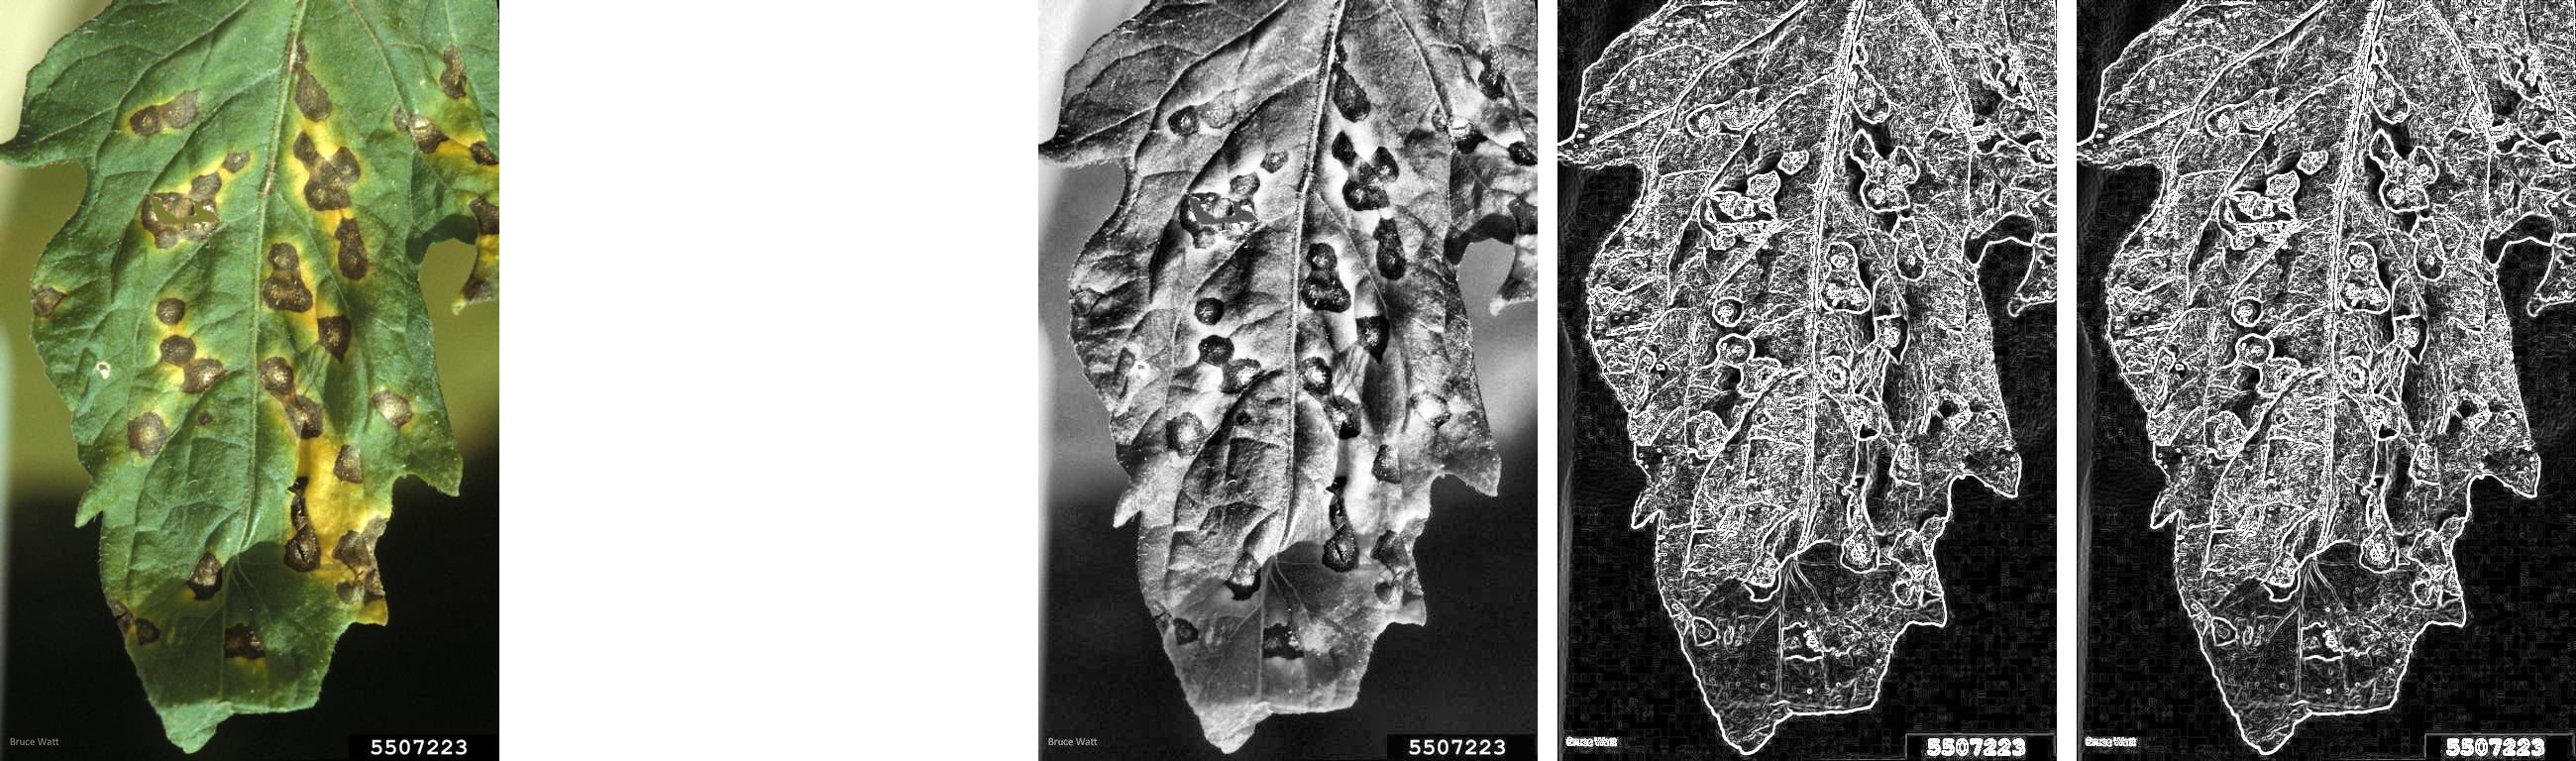

In [ ]:
image = cv2.imread(img_path)
clbp_s, clbp_m, clbp_c = completed_lbp(image)
show_clbp(image, clbp_s, clbp_m)


forntend code


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [ ]:


import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/plant_disease_model.h5")  # Ensure the correct model format

# Define image dimensions
img_width, img_height = 256, 256  # Adjust as per model requirements

# Define class labels properly (assuming 'labels' is defined in your original code)
class_labels = [
    'Bacterial_spot', 'healthy', 'Leaf_Mold', 'YellowLeaf__Curl_Virus',
    'Bacterial_spot', 'Septoria_leaf_spot', 'Early_blight',
    'Spider_mites_Two_spotted_spider_mite', 'Early_blight', 'Target_Spot',
    'Early_blight', 'Late_blight', 'Late_blight', 'Early_blight', 'mosaic_virus'
]  # Make sure 'labels' is defined correctly

def predict_image(img):
    img = img.resize((img_width, img_height))  # Resize image
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Predict class probabilities
    class_probabilities = model.predict(img_array)

    # Get the predicted class index
    predicted_label = np.argmax(class_probabilities)

    # Get predicted label name
    predicted_label_name = class_labels[predicted_label]

    return predicted_label_name


iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=1),
    title="Plant Disease Classifier"
)

iface.launch()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://959a8362afa9268ac8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
